# Potential Outcome Model

This lecture introduces the potential outcome framework for causal inference using a simulated online retail dataset. Our running example: **Does improving product content quality increase sales?**

Unlike traditional datasets where true treatment effects are unknown, our simulator lets us SET the true effect and verify whether different estimation strategies recover it.

## Learning Objectives

By the end of this lecture, you will be able to:

- Define potential outcomes, treatment indicators, and observed outcomes
- Understand individual vs population-level treatment effects (ATE, ATT, ATC)
- Recognize why naive comparisons fail due to selection bias
- Explain the SUTVA assumption and identify potential violations
- Decompose selection bias into baseline and differential effect components
- Demonstrate why randomization solves the selection problem

## Setup

In [1]:
pip install -qq git+https://github.com/eisenhauerIO/tools-catalog-generator.git

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

from online_retail_simulator import (
    simulate,
    load_job_results,
    enrich,
    register_enrichment_function,
)

from support import (
    plot_individual_effects_distribution,
    plot_treatment_parameters,
    plot_bias_decomposition,
    plot_randomization_comparison,
    plot_time_series_treatment,
    plot_bootstrap_distribution,
    plot_outcome_by_treatment,
    plot_balance_check,
)

from enrichment_selection_bias import selection_bias_boost, get_treated_products

# Register our custom enrichment function
register_enrichment_function("selection_bias_boost", selection_bias_boost)

# Set random seed for reproducibility
np.random.seed(42)

### Generate Sample Data

We simulate 500 products over a 60-day period (November 1 - December 31, 2024). The treatment (content optimization) begins on November 15.

In [3]:
print(open("config_simulation.yaml").read())

STORAGE:
  PATH: output

RULE:
  CHARACTERISTICS:
    FUNCTION: simulate_characteristics_rule_based
    PARAMS:
      num_products: 500
      seed: 42

  METRICS:
    FUNCTION: simulate_metrics_rule_based
    PARAMS:
      date_start: "2024-11-01"
      date_end: "2024-12-31"
      sale_prob: 0.7
      seed: 42

PRODUCT_DETAILS:
  FUNCTION: simulate_product_details_mock



In [4]:
# Run simulation
job_info = simulate("config_simulation.yaml")
results = load_job_results(job_info)
products = results["products"]
sales = results["sales"]

print(f"Products: {len(products)}")
print(f"Sales records: {len(sales)}")
print(f"Date range: {sales['date'].min()} to {sales['date'].max()}")

Products: 500
Sales records: 30500
Date range: 2024-11-01 to 2024-12-31


## The Potential Outcome Framework

The potential outcome framework provides a precise language for defining causal effects. For each product $i$, we define:

- $D_i \in \{0, 1\}$: Treatment indicator (1 if product receives enhanced content, 0 otherwise)
- $Y_i^1$: Potential outcome (revenue) if product $i$ receives enhanced content
- $Y_i^0$: Potential outcome (revenue) if product $i$ does not receive enhanced content

The **observed outcome** follows a switching equation:

$$Y_i = D_i \cdot Y_i^1 + (1 - D_i) \cdot Y_i^0$$

This means we only observe $Y_i^1$ for treated products and $Y_i^0$ for control products—never both.

### The Fundamental Problem of Causal Inference

Holland (1986) articulated the fundamental problem: **we cannot observe both potential outcomes for the same unit**. The counterfactual outcome is always missing.

| Product | Treatment | Observed | $Y^1$ | $Y^0$ |
|---------|-----------|----------|-------|-------|
| A | Treated | \$500 | \$500 | ? |
| B | Control | \$300 | ? | \$300 |
| C | Treated | \$450 | \$450 | ? |

The question marks represent the fundamental problem—we never observe what *would have happened* under the alternative treatment.

Let's see this fundamental problem in action with our simulated data. We'll assign a random treatment and observe how the counterfactual outcomes become missing (NaN).

In [5]:
# Demonstrate fundamental problem with actual data
# Aggregate product-level revenue for the post-treatment period
post_treatment_demo = sales[sales["date"] >= "2024-11-15"]
product_demo = post_treatment_demo.groupby("asin")["revenue"].sum().reset_index()
product_demo.columns = ["asin", "Y_0"]

# Calculate what Y_1 would be (50% boost)
product_demo["Y_1"] = product_demo["Y_0"] * 1.5

# Randomly assign treatment to 30% of products
np.random.seed(42)
product_demo["D"] = np.random.binomial(1, 0.3, len(product_demo))

# Observed outcome follows the switching equation
product_demo["Y"] = np.where(
    product_demo["D"] == 1, product_demo["Y_1"], product_demo["Y_0"]
)

# The fundamental problem: mask counterfactual outcomes with NaN
product_demo["Y_1_obs"] = np.where(product_demo["D"] == 1, product_demo["Y_1"], np.nan)
product_demo["Y_0_obs"] = np.where(product_demo["D"] == 0, product_demo["Y_0"], np.nan)

# Display sample showing NaN pattern
sample_demo = product_demo[["asin", "D", "Y", "Y_1_obs", "Y_0_obs"]].head(10)
sample_demo.columns = ["Product", "D", "Observed (Y)", "Y(1)", "Y(0)"]
sample_demo["D"] = sample_demo["D"].map({1: "Treated", 0: "Control"})
sample_demo

,Product,D,Observed (Y),Y(1),Y(0)
0,B01XWMUWBT,Control,358.200,NaN,358.20
1,B03D93TBZQ,Treated,210.000,210.000,NaN
2,B05ITPQJ1Y,Treated,1998.120,1998.120,NaN
3,B07UQNUPQZ,Control,18013.900,NaN,18013.90
4,B088O5OR15,Control,737.970,NaN,737.97
5,B0BO8WAVAY,Control,192.830,NaN,192.83
6,B0JTYL84PO,Control,581.360,NaN,581.36
7,B0LMI8X76R,Treated,1135.155,1135.155,NaN
8,B0PKUUMK56,Control,351.120,NaN,351.12
9,B0RN6HW1HS,Treated,620.520,620.520,NaN


## Individual-Specific Treatment Effects

The individual treatment effect for product $i$ is:

$$\delta_i = Y_i^1 - Y_i^0$$

This measures how much product $i$'s revenue would change due to content optimization.

**Simulator Advantage**: Unlike real data, we can actually compute true individual effects because we control the data generating process. Let's demonstrate by generating both potential outcomes for each product.

In [6]:
# Treatment parameters
EFFECT_SIZE = 0.5  # 50% boost
TREATMENT_FRACTION = 0.3  # 30% of products
TREATMENT_START = "2024-11-15"

# Define pre and post treatment periods
pre_treatment = sales[sales["date"] < TREATMENT_START]
post_treatment = sales[sales["date"] >= TREATMENT_START]

# Aggregate to product level for post-treatment period (baseline - no treatment applied yet)
product_baseline = (
    post_treatment.groupby("asin")
    .agg({"revenue": "sum", "ordered_units": "sum"})
    .reset_index()
)
product_baseline.columns = ["asin", "Y_0", "units_0"]

# Y_1 is Y_0 boosted by the effect size
product_baseline["Y_1"] = product_baseline["Y_0"] * (1 + EFFECT_SIZE)

# True individual treatment effect
product_baseline["delta"] = product_baseline["Y_1"] - product_baseline["Y_0"]
product_baseline["delta_pct"] = product_baseline["delta"] / product_baseline["Y_0"]

print(f"True effect size: {EFFECT_SIZE:.0%}")
print(f"Mean individual effect: ${product_baseline['delta'].mean():,.2f}")
print(f"Std of individual effects: ${product_baseline['delta'].std():,.2f}")

True effect size: 50%
Mean individual effect: $1,067.15
Std of individual effects: $1,869.42


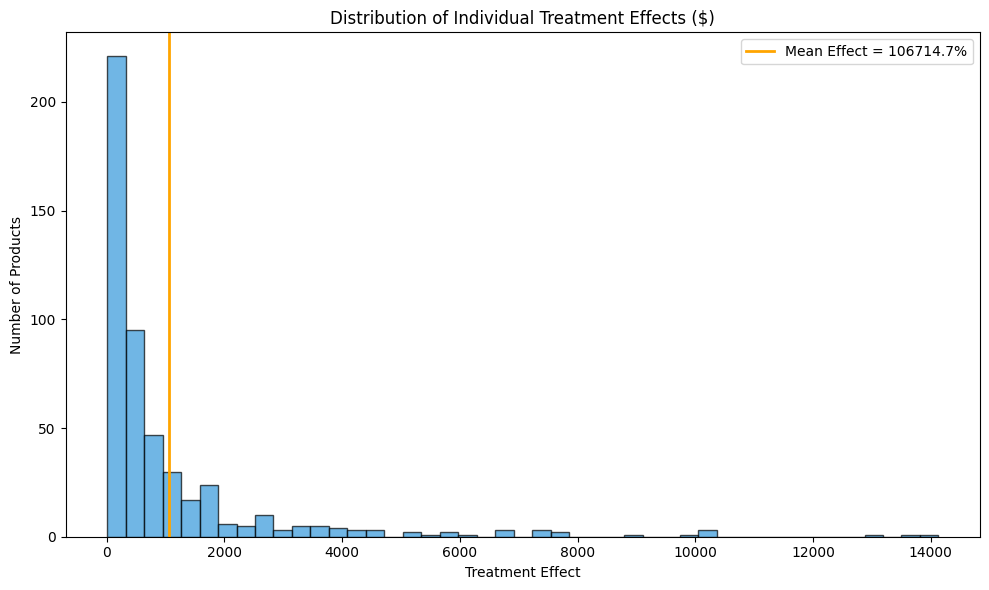

In [7]:
plot_individual_effects_distribution(
    product_baseline["delta"],
    true_effect=None,
    title="Distribution of Individual Treatment Effects ($)",
)

Notice that even with a fixed 50% effect size, individual effects vary because products have different baseline revenues. A product with \$1000 baseline gains \$500, while one with \$100 baseline gains only \$50.

## Population-Level Parameters

Since we cannot observe individual effects in practice, we focus on population averages:

| Parameter | Definition | Question Answered |
|-----------|------------|-------------------|
| **ATE** | $E[Y^1 - Y^0]$ | Average effect across ALL products |
| **ATT** | $E[Y^1 - Y^0 \mid D=1]$ | Effect among products that WERE optimized |
| **ATC** | $E[Y^1 - Y^0 \mid D=0]$ | Effect if we optimized the remaining products |

In [8]:
# Calculate true population parameters
# For now, with uniform effect, ATE = ATT = ATC

ATE_true = product_baseline["delta"].mean()

print(f"True ATE: ${ATE_true:,.2f}")
print("\nThis represents the average revenue increase from content optimization.")

True ATE: $1,067.15

This represents the average revenue increase from content optimization.


In [9]:
# With heterogeneous effects by product size, we'd see ATE != ATT != ATC
# Let's simulate this by making effect larger for higher-priced products

# Merge price information
product_with_price = product_baseline.merge(
    products[["asin", "price", "category"]], on="asin"
)

# Create heterogeneous effect: higher-priced products benefit more
median_price = product_with_price["price"].median()
product_with_price["effect_multiplier"] = np.where(
    product_with_price["price"] > median_price, 1.2, 0.8
)
product_with_price["delta_hetero"] = (
    product_with_price["Y_0"] * EFFECT_SIZE * product_with_price["effect_multiplier"]
)

# Suppose we treat high-priced products
product_with_price["D"] = (product_with_price["price"] > median_price).astype(int)

ATE_hetero = product_with_price["delta_hetero"].mean()
ATT_hetero = product_with_price[product_with_price["D"] == 1]["delta_hetero"].mean()
ATC_hetero = product_with_price[product_with_price["D"] == 0]["delta_hetero"].mean()

print("With heterogeneous effects (high-priced products benefit more):")
print(f"ATE: ${ATE_hetero:,.2f}")
print(f"ATT: ${ATT_hetero:,.2f}")
print(f"ATC: ${ATC_hetero:,.2f}")

With heterogeneous effects (high-priced products benefit more):
ATE: $1,236.38
ATT: $2,295.96
ATC: $176.80


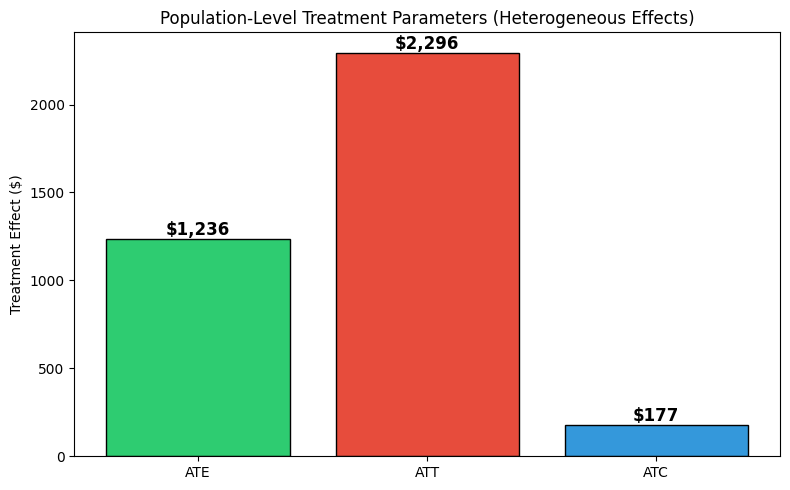

In [10]:
plot_treatment_parameters(
    ATE_hetero,
    ATT_hetero,
    ATC_hetero,
    title="Population-Level Treatment Parameters (Heterogeneous Effects)",
)

## SUTVA: Stable Unit Treatment Value Assumption

The potential outcome framework relies on SUTVA, which requires:

1. **No interference**: One product's treatment doesn't affect another product's outcomes
2. **No hidden variations**: Treatment is well-defined (no multiple versions)

### Potential SUTVA Violations in E-commerce

| Violation | Example | Implication |
|-----------|---------|-------------|
| **Cannibalization** | Better content on Product A steals sales from Product B | Interference between products |
| **Market saturation** | If ALL products are optimized, relative advantage disappears | Effect depends on treatment prevalence |
| **Budget constraints** | Customers have fixed budgets; more on A means less on B | Zero-sum dynamics |

## Naive Estimation and Selection Bias

The **naive estimator** compares average outcomes between treated and control groups:

$$\hat{\delta}_{NAIVE} = E[Y \mid D=1] - E[Y \mid D=0]$$

This equals the ATE only if treatment is independent of potential outcomes. In practice, businesses don't randomly select products for optimization—they prioritize their best sellers.

Let's demonstrate this with our `selection_bias_boost` function that treats TOP performers.

In [11]:
print(open("config_enrichment_biased.yaml").read())

IMPACT:
  FUNCTION: selection_bias_boost
  PARAMS:
    effect_size: 0.5
    ramp_days: 0
    enrichment_fraction: 0.3
    enrichment_start: "2024-11-15"
    seed: 42



In [12]:
# Apply biased selection enrichment
biased_job = enrich("config_enrichment_biased.yaml", job_info)
biased_results = load_job_results(biased_job)
biased_sales = biased_results["enriched"]

print(f"Enriched sales records: {len(biased_sales)}")

Enriched sales records: 30500


In [13]:
# Identify which products were treated (top performers)
sales_list = sales.to_dict("records")
treated_products = get_treated_products(
    sales_list, enrichment_fraction=TREATMENT_FRACTION, enrichment_start=TREATMENT_START
)

print(f"Number of treated products: {len(treated_products)}")
print(f"Treatment fraction: {len(treated_products) / len(products):.1%}")

Number of treated products: 150
Treatment fraction: 30.0%


In [14]:
# Aggregate post-treatment outcomes
post_biased = biased_sales[biased_sales["date"] >= TREATMENT_START]
product_outcomes = post_biased.groupby("asin")["revenue"].sum().reset_index()
product_outcomes.columns = ["asin", "Y"]

# Add treatment indicator
product_outcomes["D"] = product_outcomes["asin"].isin(treated_products).astype(int)

# Compute naive estimate
treated_mean = product_outcomes[product_outcomes["D"] == 1]["Y"].mean()
control_mean = product_outcomes[product_outcomes["D"] == 0]["Y"].mean()
naive_estimate = treated_mean - control_mean

print(f"Mean revenue (Treated):  ${treated_mean:,.2f}")
print(f"Mean revenue (Control):  ${control_mean:,.2f}")
print(f"Naive estimate:          ${naive_estimate:,.2f}")
print(f"True ATE:                ${ATE_true:,.2f}")
print(f"\nBias: ${naive_estimate - ATE_true:,.2f}")

Mean revenue (Treated):  $5,895.04
Mean revenue (Control):  $1,117.99
Naive estimate:          $4,777.05
True ATE:                $1,067.15

Bias: $3,709.91


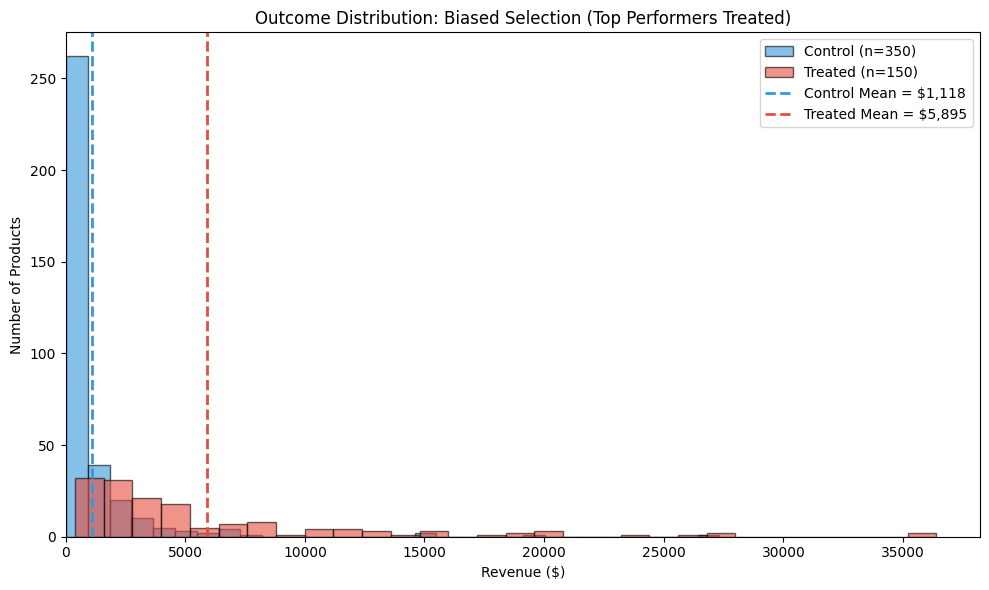

In [15]:
# Visualize outcome distributions by treatment status
treated_outcomes_biased = product_outcomes[product_outcomes["D"] == 1]["Y"]
control_outcomes_biased = product_outcomes[product_outcomes["D"] == 0]["Y"]

plot_outcome_by_treatment(
    treated_outcomes_biased,
    control_outcomes_biased,
    title="Outcome Distribution: Biased Selection (Top Performers Treated)",
)

### Why Does the Naive Estimate Overestimate?

The naive estimate includes both the true treatment effect AND selection bias:

$$\text{Naive} = \text{ATE} + \underbrace{E[Y^0 \mid D=1] - E[Y^0 \mid D=0]}_{\text{Baseline Bias}}$$

**Baseline bias** arises because treated products (top performers) would have had higher revenue *even without treatment*.

In [16]:
# Calculate baseline bias
# We need baseline (pre-treatment) revenue to see the selection
pre_revenue = pre_treatment.groupby("asin")["revenue"].sum().reset_index()
pre_revenue.columns = ["asin", "baseline_revenue"]

product_outcomes = product_outcomes.merge(pre_revenue, on="asin")

# Baseline revenue by treatment status
baseline_treated = product_outcomes[product_outcomes["D"] == 1][
    "baseline_revenue"
].mean()
baseline_control = product_outcomes[product_outcomes["D"] == 0][
    "baseline_revenue"
].mean()
baseline_bias = baseline_treated - baseline_control

print(f"Baseline revenue (Treated):  ${baseline_treated:,.2f}")
print(f"Baseline revenue (Control):  ${baseline_control:,.2f}")
print(f"Baseline bias:               ${baseline_bias:,.2f}")
print("\nThis shows treated products were ALREADY better performers!")

Baseline revenue (Treated):  $1,698.39
Baseline revenue (Control):  $112.79
Baseline bias:               $1,585.61

This shows treated products were ALREADY better performers!


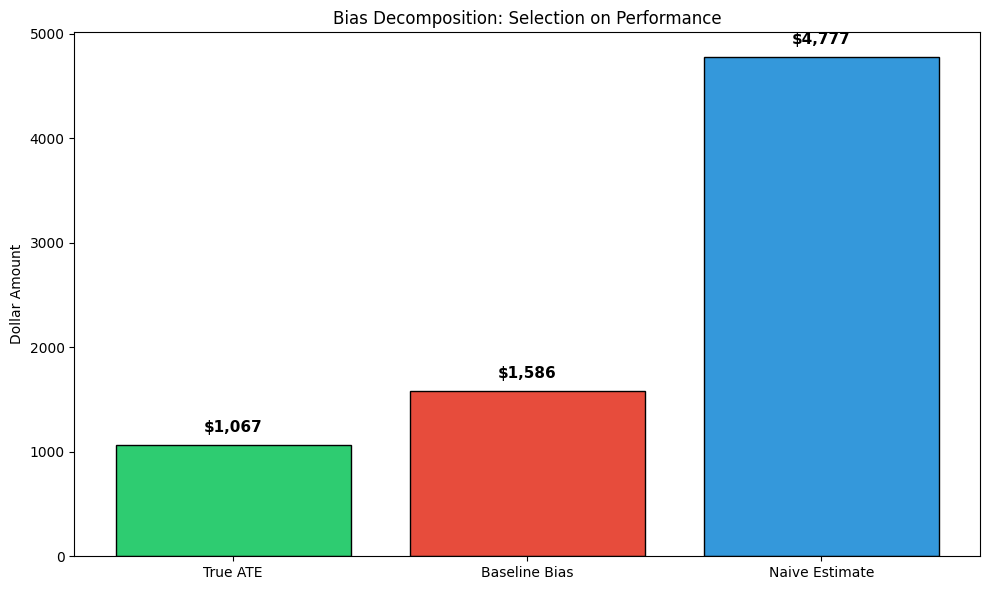

In [17]:
plot_bias_decomposition(
    ate=ATE_true,
    baseline_bias=baseline_bias,
    naive_estimate=naive_estimate,
    title="Bias Decomposition: Selection on Performance",
)

## Randomization as the Solution

Randomization breaks the link between treatment assignment and potential outcomes:

$$(Y^0, Y^1) \perp\!\!\!\perp D$$

Under randomization, the naive estimator is unbiased:

$$E[Y \mid D=1] - E[Y \mid D=0] = E[Y^1] - E[Y^0] = \text{ATE}$$

Let's compare random selection (`combined_boost`) with biased selection (`selection_bias_boost`).

In [18]:
print("Random selection config:")
print(open("config_enrichment_random.yaml").read())

Random selection config:
IMPACT:
  FUNCTION: combined_boost
  PARAMS:
    effect_size: 0.5
    ramp_days: 0
    enrichment_fraction: 0.3
    enrichment_start: "2024-11-15"
    seed: 42



In [19]:
# Apply random selection enrichment
random_job = enrich("config_enrichment_random.yaml", job_info)
random_results = load_job_results(random_job)
random_sales = random_results["enriched"]

# Get treated products (for random selection, we need to track this differently)
# We'll identify by comparing pre/post revenue ratios
post_random = random_sales[random_sales["date"] >= TREATMENT_START]
random_outcomes = post_random.groupby("asin")["revenue"].sum().reset_index()
random_outcomes.columns = ["asin", "Y"]

# Compare with original (no treatment) to identify treated
post_original = sales[sales["date"] >= TREATMENT_START]
original_outcomes = post_original.groupby("asin")["revenue"].sum().reset_index()
original_outcomes.columns = ["asin", "Y_original"]

random_outcomes = random_outcomes.merge(original_outcomes, on="asin")
random_outcomes["ratio"] = random_outcomes["Y"] / random_outcomes["Y_original"]
random_outcomes["D"] = (random_outcomes["ratio"] > 1.1).astype(
    int
)  # Treated if >10% boost

# Naive estimate under random assignment
treated_mean_random = random_outcomes[random_outcomes["D"] == 1]["Y"].mean()
control_mean_random = random_outcomes[random_outcomes["D"] == 0]["Y"].mean()
naive_random = treated_mean_random - control_mean_random

print("Random selection:")
print(f"  Mean revenue (Treated):  ${treated_mean_random:,.2f}")
print(f"  Mean revenue (Control):  ${control_mean_random:,.2f}")
print(f"  Naive estimate:          ${naive_random:,.2f}")
print(f"  True ATE:                ${ATE_true:,.2f}")
print(f"  Bias:                    ${naive_random - ATE_true:,.2f}")

Random selection:
  Mean revenue (Treated):  $2,583.27
  Mean revenue (Control):  $2,208.78
  Naive estimate:          $374.50
  True ATE:                $1,067.15
  Bias:                    $-692.65


### Verifying Balance: Why Randomization Works

A key diagnostic for randomization is checking **covariate balance** - treated and control groups should have similar distributions of baseline characteristics. Let's compare balance under random vs biased selection.

BIASED SELECTION (Top Performers)


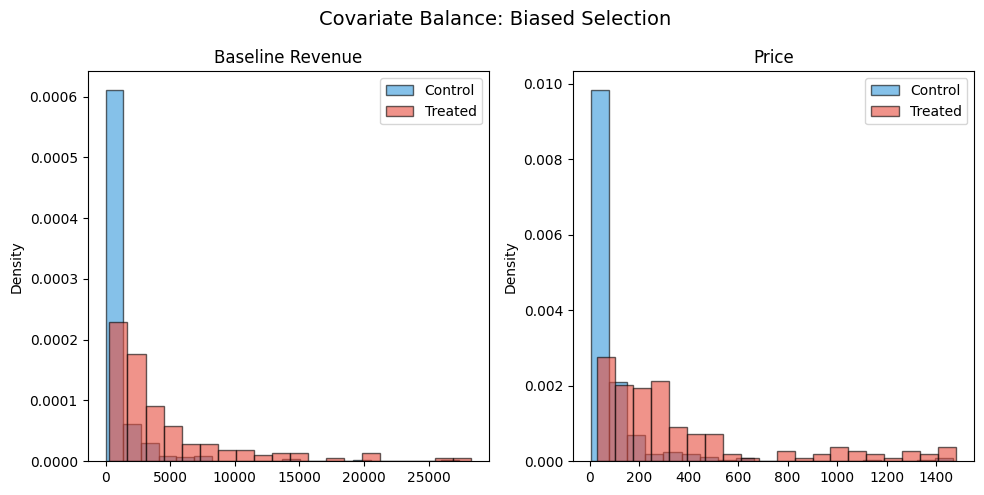


Balance Summary (Mean by Treatment Status):
--------------------------------------------------
baseline_revenue    : Control= 1117.99, Treated= 4505.68, Diff=+3387.70
price               : Control=   93.37, Treated=  383.62, Diff= +290.25


RANDOM SELECTION


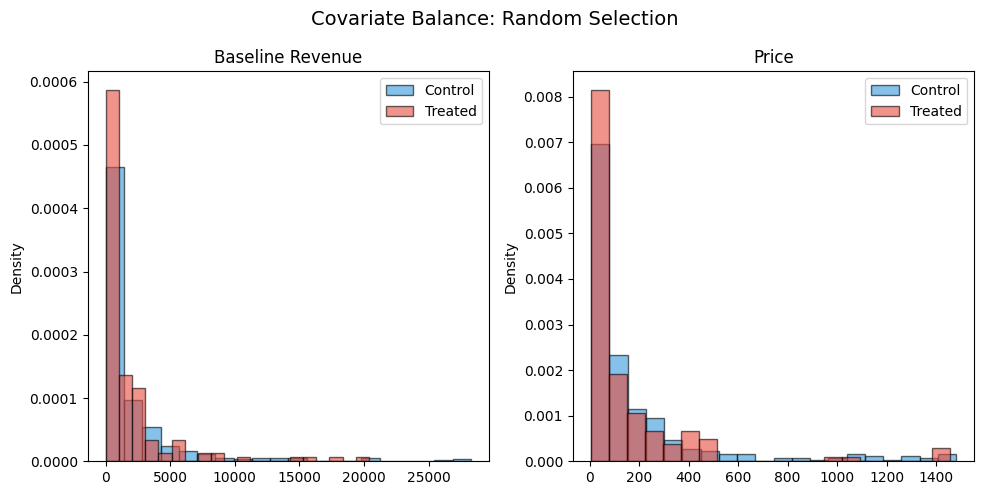


Balance Summary (Mean by Treatment Status):
--------------------------------------------------
baseline_revenue    : Control= 2208.38, Treated= 1951.14, Diff= -257.24
price               : Control=  191.03, Treated=  154.29, Diff=  -36.74


In [20]:
# Prepare data for balance check
# Merge baseline revenue and price info with treatment indicators
balance_df = product_baseline[["asin", "Y_0"]].merge(
    products[["asin", "price"]], on="asin"
)
balance_df = balance_df.rename(columns={"Y_0": "baseline_revenue"})

# Add treatment indicators for both selection methods
balance_df["D_random"] = (
    balance_df["asin"]
    .isin(random_outcomes[random_outcomes["D"] == 1]["asin"])
    .astype(int)
)
balance_df["D_biased"] = balance_df["asin"].isin(treated_products).astype(int)

# Compare balance for biased selection
print("=" * 60)
print("BIASED SELECTION (Top Performers)")
print("=" * 60)
plot_balance_check(
    balance_df,
    covariates=["baseline_revenue", "price"],
    treatment_col="D_biased",
    title="Covariate Balance: Biased Selection",
)

print("\n")
print("=" * 60)
print("RANDOM SELECTION")
print("=" * 60)
plot_balance_check(
    balance_df,
    covariates=["baseline_revenue", "price"],
    treatment_col="D_random",
    title="Covariate Balance: Random Selection",
)

The balance checks reveal the selection problem:
- **Biased selection**: Treated products have much higher baseline revenue and prices - they were already top performers
- **Random selection**: Treated and control groups have similar baseline characteristics - balance is achieved

This visual confirmation of balance is a practical skill for evaluating any causal study.

### Monte Carlo Comparison

Let's run multiple simulations to see the distribution of estimates under random vs biased selection.

In [21]:
# Monte Carlo simulation comparing random vs biased selection
n_simulations = 100

random_estimates = []
biased_estimates = []

# Get baseline data
baseline_df = product_baseline.copy()

for i in range(n_simulations):
    # Random selection
    n_treated = int(len(baseline_df) * TREATMENT_FRACTION)
    random_idx = np.random.choice(len(baseline_df), n_treated, replace=False)
    baseline_df["D_random"] = 0
    baseline_df.iloc[random_idx, baseline_df.columns.get_loc("D_random")] = 1

    # Observed outcome under random assignment
    baseline_df["Y_random"] = np.where(
        baseline_df["D_random"] == 1, baseline_df["Y_1"], baseline_df["Y_0"]
    )

    est_random = (
        baseline_df[baseline_df["D_random"] == 1]["Y_random"].mean()
        - baseline_df[baseline_df["D_random"] == 0]["Y_random"].mean()
    )
    random_estimates.append(est_random)

    # Biased selection (top performers)
    top_idx = baseline_df.nlargest(n_treated, "Y_0").index
    baseline_df["D_biased"] = 0
    baseline_df.loc[top_idx, "D_biased"] = 1

    # Observed outcome under biased assignment
    baseline_df["Y_biased"] = np.where(
        baseline_df["D_biased"] == 1, baseline_df["Y_1"], baseline_df["Y_0"]
    )

    est_biased = (
        baseline_df[baseline_df["D_biased"] == 1]["Y_biased"].mean()
        - baseline_df[baseline_df["D_biased"] == 0]["Y_biased"].mean()
    )
    biased_estimates.append(est_biased)

print(
    f"Random selection:  Mean = ${np.mean(random_estimates):,.0f}, Std = ${np.std(random_estimates):,.0f}"
)
print(
    f"Biased selection:  Mean = ${np.mean(biased_estimates):,.0f}, Std = ${np.std(biased_estimates):,.0f}"
)
print(f"True ATE:          ${ATE_true:,.0f}")

Random selection:  Mean = $1,047, Std = $455
Biased selection:  Mean = $7,994, Std = $0
True ATE:          $1,067


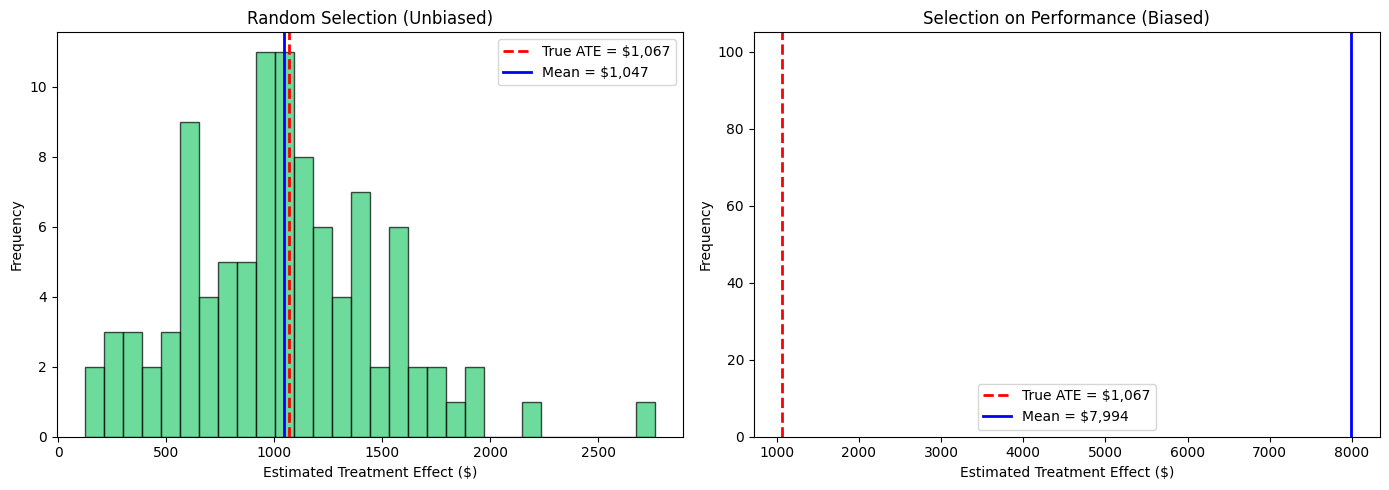

In [22]:
plot_randomization_comparison(random_estimates, biased_estimates, ATE_true)

The histograms show that:
- **Random selection** (left): Estimates are centered around the true ATE
- **Biased selection** (right): Estimates are systematically too high due to selection bias

## Missing Data and Imputation Perspective

Causal inference can be framed as a missing data problem. For each product, one potential outcome is always missing:

| Product | D | Y | $Y^1$ | $Y^0$ |
|---------|---|---|-------|-------|
| A | 1 | 500 | 500 | ? |
| B | 0 | 300 | ? | 300 |

We can impute the missing counterfactuals using various strategies.

In [23]:
# Create a dataset showing the fundamental problem
display_df = baseline_df[["asin", "Y_0", "Y_1"]].copy()

# Assign random treatment for demonstration
np.random.seed(123)
display_df["D"] = np.random.binomial(1, TREATMENT_FRACTION, len(display_df))

# Observed outcome
display_df["Y"] = np.where(display_df["D"] == 1, display_df["Y_1"], display_df["Y_0"])

# Mask the counterfactual
display_df["Y_1_observed"] = np.where(display_df["D"] == 1, display_df["Y_1"], np.nan)
display_df["Y_0_observed"] = np.where(display_df["D"] == 0, display_df["Y_0"], np.nan)

# Show sample
sample = display_df[["asin", "D", "Y", "Y_1_observed", "Y_0_observed"]].sample(
    10, random_state=42
)
sample.columns = ["Product", "Treated", "Observed", "Y(1)", "Y(0)"]
sample["Treated"] = sample["Treated"].map({1: "Yes", 0: "No"})
sample

,Product,Treated,Observed,Y(1),Y(0)
361,BPWKCZV1GA,No,810.29,NaN,810.29
73,B529S85ML8,Yes,6100.20,6100.20,NaN
374,BQQ81XRZN0,Yes,4041.18,4041.18,NaN
155,B9WEU7OL7E,No,2786.58,NaN,2786.58
104,B70X3FG6IZ,No,548.60,NaN,548.60
394,BSDP5YHP5E,No,758.24,NaN,758.24
377,BR7CETEN7G,No,4977.12,NaN,4977.12
124,B8BYW485W6,Yes,373.86,373.86,NaN
68,B4VPAAFH5J,No,661.95,NaN,661.95
450,BXC71O4YWG,No,227.92,NaN,227.92


### Bootstrap for Uncertainty Quantification

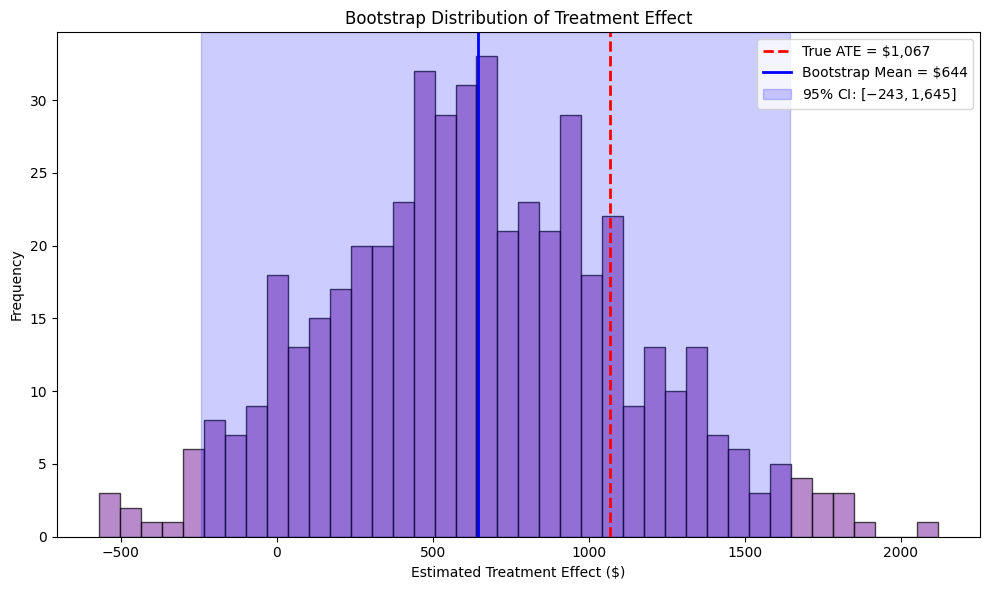


95% Confidence Interval: [$-243, $1,645]


In [24]:
# Bootstrap estimation
np.random.seed(456)
n_bootstrap = 500
bootstrap_estimates = []

treated_outcomes = display_df[display_df["D"] == 1]["Y"].values
control_outcomes = display_df[display_df["D"] == 0]["Y"].values

for _ in range(n_bootstrap):
    # Resample with replacement
    treated_sample = np.random.choice(
        treated_outcomes, len(treated_outcomes), replace=True
    )
    control_sample = np.random.choice(
        control_outcomes, len(control_outcomes), replace=True
    )

    estimate = treated_sample.mean() - control_sample.mean()
    bootstrap_estimates.append(estimate)

ci_low, ci_high = plot_bootstrap_distribution(
    bootstrap_estimates,
    true_ate=ATE_true,
    title="Bootstrap Distribution of Treatment Effect",
)

print(f"\n95% Confidence Interval: [${ci_low:,.0f}, ${ci_high:,.0f}]")

## Extensions: Time Series View

The potential outcome framework extends to panel data. Before treatment ($t < t^*$), all products are in control state. After treatment ($t \geq t^*$), treated products switch to the treatment potential outcome.

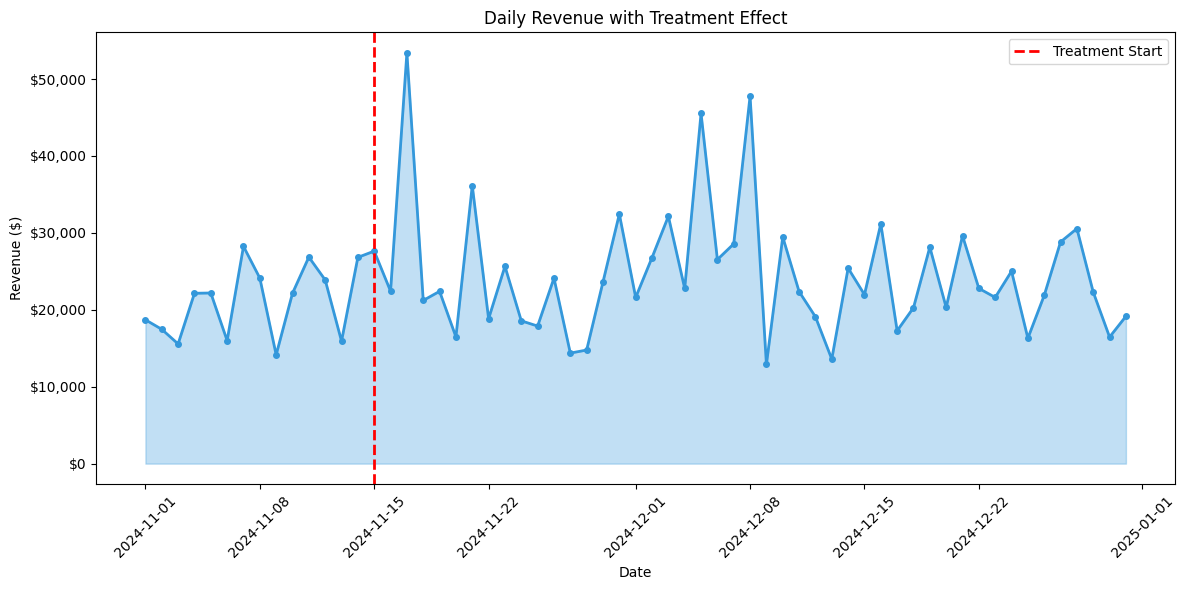

In [25]:
# Compare daily revenue: original vs enriched (random selection)
daily_original = sales.groupby("date")["revenue"].sum().reset_index()
daily_enriched = random_sales.groupby("date")["revenue"].sum().reset_index()

# Merge for comparison
daily_comparison = daily_original.merge(
    daily_enriched, on="date", suffixes=("_original", "_enriched")
)

plot_time_series_treatment(
    daily_comparison.rename(columns={"revenue_enriched": "revenue"}),
    TREATMENT_START,
    title="Daily Revenue with Treatment Effect",
)

The jump after November 15 reflects the treatment effect. This time-series view previews the **difference-in-differences** approach we'll cover in a later lecture.

## Summary

| Concept | Definition | E-commerce Example |
|---------|------------|-------------------|
| Treatment ($D$) | Binary indicator | Content optimization (yes/no) |
| Potential Outcomes | $Y^1$, $Y^0$ | Revenue with/without optimization |
| Fundamental Problem | Cannot observe both $Y^1$ and $Y^0$ | Cannot see what sales would have been |
| ATE | $E[Y^1 - Y^0]$ | Average effect across all products |
| Selection Bias | $E[Y^0|D=1] - E[Y^0|D=0]$ | High-performers selected for optimization |
| Randomization | $(Y^0, Y^1) \perp\!\!\!\perp D$ | Random A/B test assignment |

### Key Takeaways

1. **The simulator advantage**: We can SET and KNOW the true treatment effect
2. **Naive comparisons fail** when selection is non-random
3. **Randomization solves** the selection bias problem
4. This framework **underlies all causal identification strategies** we'll cover next